# Step 5

## Predict behavioral performance from the match of the gradients

We combine steps 2 and 4 to investigate a potential behavioral relevance of the match of time series to gradients

In [1]:
%matplotlib inline

import numpy as np
import h5py as h5
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from fgrad.predict import features_targets, predict_performance

/usr/local/lib/python2.7/site-packages/nibabel/cifti2/parse_cifti2.py:24: FutureWarning: We no longer carry a copy of the 'six' package in nibabel; Please import the 'six' package directly
  from ..externals.six import BytesIO


## Prepare the features

Same as in Step 3, we simply calculate the average values for each 100-subject group

In [2]:
f = h5.File('/Users/marcel/projects/HCP/volumes_embedded_full.hdf5')
d_LR = f['Working_memory/Run1']
d_RL = f['Working_memory/Run2']

In [3]:
labels = dict()
labels['WM_fix'] = 0
labels['WM_0back'] = 1
labels['WM_2back'] = 2

# Block onsets expressed as TRs
# We add 6 volumes (4.32 s) to each onset to take into account hemodynamic lag 
# and additional 4 volumes (2.88 s) to account for instruction
nback_LR_2b = np.round(np.array([7.977, 79.369, 150.553, 178.689])/0.72).astype(int)+10
nback_LR_0b = np.round(np.array([36.159, 107.464, 221.965, 250.18])/0.72).astype(int)+10
nback_RL_2b = np.round(np.array([7.977, 79.369, 178.769, 250.22])/0.72).astype(int)+10
nback_RL_0b = np.round(np.array([36.159, 107.464, 150.567, 222.031])/0.72).astype(int)+10
nback_fix = np.array([88, 187, 286])+6

# Each block lasts for 27.5 seconds
vols_2b_LR = np.concatenate([range(x,x+38) for x in nback_LR_2b])
vols_0b_LR = np.concatenate([range(x,x+38) for x in nback_LR_0b])
vols_2b_RL = np.concatenate([range(x,x+38) for x in nback_RL_2b])
vols_0b_RL = np.concatenate([range(x,x+38) for x in nback_RL_0b])
vols_fix = np.concatenate([range(x,x+22) for x in nback_fix])
vols_fix = np.concatenate([vols_fix, range(395, 405)])

# Targets
nback_targets_LR = np.zeros(405)
nback_targets_LR[vols_2b_LR] = 1
nback_targets_LR[vols_fix] = -1

nback_targets_RL = np.zeros(405)
nback_targets_RL[vols_2b_RL] = 1
nback_targets_RL[vols_fix] = -1

In [4]:
# Get random group assignments
subjects = f['Working_memory/Subjects'][...]
np.random.seed(123)
sind = np.arange(len(subjects))
G1 = sorted(np.random.choice(sind, 100, replace = False ))
sind = np.delete(sind,G1)
G2 = sorted(np.random.choice(sind, 100, replace = False ))
sind = np.delete(sind,G2)
G3 = sorted(np.random.choice(sind, 100, replace = False ))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


In [5]:
conds = ['WM_fix', 'WM_0back', 'WM_2back']
grads = [0,1,2]

# Group 1

f_WM_train1, t_WM_train1 = features_targets(data = d_LR, subjects = G1, 
                                      inds = nback_targets_LR, condnames = conds, gradients = grads, labels = labels)

f_WM_train2, t_WM_train2 = features_targets(data = d_RL, subjects = G1, 
                                      inds = nback_targets_RL, condnames = conds, gradients = grads, labels = labels)

# Group 2

f_WM_train3, t_WM_train3 = features_targets(data = d_LR, subjects = G2, 
                                      inds = nback_targets_LR, condnames = conds, gradients = grads, labels = labels)

f_WM_train4, t_WM_train4 = features_targets(data = d_RL, subjects = G2, 
                                      inds = nback_targets_RL, condnames = conds, gradients = grads, labels = labels)

# Group 3

f_WM_test1, t_WM_test1 = features_targets(data = d_LR, subjects = G3, 
                                      inds = nback_targets_LR, condnames = conds, gradients = grads, labels = labels)

f_WM_test2, t_WM_test2 = features_targets(data = d_RL, subjects = G3, 
                                      inds = nback_targets_RL, condnames = conds, gradients = grads, labels = labels)

## Prepare targets

Get the estimated d-prime and bias and try to predict them from the gradient match

In [6]:
data_performance = pd.read_csv('../data/WM_SDT.csv', index_col=0)

data_performance.subject_id = data_performance.subject_id.astype('str')

data_performance = data_performance.reset_index(drop = True)

In [7]:
G1_ID = subjects[G1]
G2_ID = subjects[G2]
G3_ID = subjects[G3]

In [8]:
# Indices to include from the behavioral data
WM_ind_G1 = []
WM_ind_G2 = []
WM_ind_G3 = []

# These are the indices of features to remove because of missing data
remove_G1 = []
remove_G2 = []
remove_G3 = []

for i, n in enumerate(G1_ID):
    try:
        WM_ind_G1.append(np.where(data_performance.iloc[:,0] == n)[0][0])
    except:
        remove_G1.append(i)

for i, n in enumerate(G2_ID):
    try:
        WM_ind_G2.append(np.where(data_performance.iloc[:,0] == n)[0][0])
    except:
        remove_G2.append(i)
    
for i, n in enumerate(G3_ID):
    try:
        WM_ind_G3.append(np.where(data_performance.iloc[:,0] == n)[0][0])
    except:
        remove_G3.append(i)

#### Prepare the vectors

In [9]:
t_WM_2b_train1 = data_performance['dprime_2b_LR'][WM_ind_G1]
t_WM_2b_train2 = data_performance['dprime_2b_RL'][WM_ind_G1]
t_WM_2b_train3 = data_performance['dprime_2b_LR'][WM_ind_G2]
t_WM_2b_train4 = data_performance['dprime_2b_RL'][WM_ind_G2]
t_WM_2b_test1 = data_performance['dprime_2b_LR'][WM_ind_G3]
t_WM_2b_test2 = data_performance['dprime_2b_RL'][WM_ind_G3]

t_WM_0b_train1 = data_performance['dprime_0b_LR'][WM_ind_G1]
t_WM_0b_train2 = data_performance['dprime_0b_RL'][WM_ind_G1]
t_WM_0b_train3 = data_performance['dprime_0b_LR'][WM_ind_G2]
t_WM_0b_train4 = data_performance['dprime_0b_RL'][WM_ind_G2]
t_WM_0b_test1 = data_performance['dprime_0b_LR'][WM_ind_G3]
t_WM_0b_test2 = data_performance['dprime_0b_RL'][WM_ind_G3]

f_WM_2b_t1 = np.delete(f_WM_train1[2::3], remove_G1, axis = 0)
f_WM_2b_t2 = np.delete(f_WM_train2[2::3], remove_G1, axis = 0)
f_WM_2b_t3 = np.delete(f_WM_train3[2::3], remove_G2, axis = 0)
f_WM_2b_t4 = np.delete(f_WM_train4[2::3], remove_G2, axis = 0)
f_WM_2b_test1 = np.delete(f_WM_test1[2::3], remove_G3, axis = 0)
f_WM_2b_test2 = np.delete(f_WM_test2[2::3], remove_G3, axis = 0)

f_WM_0b_t1 = np.delete(f_WM_train1[1::3], remove_G1, axis = 0)
f_WM_0b_t2 = np.delete(f_WM_train2[1::3], remove_G1, axis = 0)
f_WM_0b_t3 = np.delete(f_WM_train3[1::3], remove_G2, axis = 0)
f_WM_0b_t4 = np.delete(f_WM_train4[1::3], remove_G2, axis = 0)
f_WM_0b_test1 = np.delete(f_WM_test1[1::3], remove_G3, axis = 0)
f_WM_0b_test2 = np.delete(f_WM_test2[1::3], remove_G3, axis = 0)

## Predict performance

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score
import statsmodels.api as sm

### 2-back

In [11]:
features_A_2b = np.vstack([f_WM_2b_t1, f_WM_2b_t2])
features_B_2b = np.vstack([f_WM_2b_t3, f_WM_2b_t4])
features_C_2b = np.vstack([f_WM_2b_test1, f_WM_2b_test2])

targets_A_2b = np.concatenate([t_WM_2b_train1, t_WM_2b_train2])
targets_B_2b = np.concatenate([t_WM_2b_train3, t_WM_2b_train4])
targets_C_2b = np.concatenate([t_WM_2b_test1, t_WM_2b_test2])

In [12]:
predict_performance(features_A_2b, targets_A_2b, features_B_2b, targets_B_2b, features_C_2b, targets_C_2b)

Gradients   AIC   BIC   A (B, C)              AIC   BIC   B (A, C)              AIC   BIC   C (A, B)
[0]         409.9 416.4 0.03 (0.01, 0.04)     377.9 384.2 0.02 (0.03, 0.03)     375.3 381.7 0.04 (0.03, 0.01)
[1]         381.0 387.5 0.17 (0.10, 0.12)     360.5 366.9 0.11 (0.16, 0.12)     359.5 365.9 0.12 (0.16, 0.11)
[2]         383.0 389.5 0.16 (0.08, 0.10)     363.1 369.5 0.09 (0.14, 0.11)     361.3 367.7 0.11 (0.15, 0.09)
[0, 1]      379.6 389.4 0.18 (0.10, 0.15)     361.3 370.9 0.11 (0.17, 0.14)     354.3 363.9 0.16 (0.17, 0.10)
[0, 2]      381.9 391.7 0.17 (0.06, 0.11)     365.1 374.7 0.09 (0.14, 0.12)     360.8 370.4 0.13 (0.16, 0.08)
[1, 2]      371.4 381.1 0.22 (0.13, 0.18)     356.2 365.8 0.14 (0.21, 0.18)     349.2 358.8 0.18 (0.21, 0.13)
[0, 1, 2]   370.8 383.8 0.23 (0.11, 0.19)     358.1 370.9 0.14 (0.21, 0.18)     348.0 360.9 0.19 (0.22, 0.12)


In [13]:
ols = sm.OLS(targets_A_2b, sm.add_constant(features_A_2b))
ols = ols.fit(cov_type="HC1")
print ols.summary()
pred_2b_A_B = ols.predict(sm.add_constant(features_B_2b))
pred_2b_A_C = ols.predict(sm.add_constant(features_C_2b))

print "Variance explained (B): %.2f" % explained_variance_score(targets_B_2b, pred_2b_A_B)
print "Variance explained (C): %.2f" % explained_variance_score(targets_C_2b, pred_2b_A_C)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     21.10
Date:                Thu, 06 Apr 2017   Prob (F-statistic):           8.25e-12
Time:                        13:46:25   Log-Likelihood:                -181.42
No. Observations:                 190   AIC:                             370.8
Df Residuals:                     186   BIC:                             383.8
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5710      0.127     12.322      0.0

In [15]:
ols = sm.OLS(targets_B_2b, sm.add_constant(features_B_2b))
ols = ols.fit(cov_type="HC1")
print ols.summary()
pred_2b_B_A = ols.predict(sm.add_constant(features_A_2b))
pred_2b_B_C = ols.predict(sm.add_constant(features_C_2b))

print "Variance explained (A): %.2f" % explained_variance_score(targets_A_2b, pred_2b_B_A)
print "Variance explained (C): %.2f" % explained_variance_score(targets_C_2b, pred_2b_B_C)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     9.216
Date:                Thu, 06 Apr 2017   Prob (F-statistic):           1.07e-05
Time:                        13:46:25   Log-Likelihood:                -175.06
No. Observations:                 180   AIC:                             358.1
Df Residuals:                     176   BIC:                             370.9
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7500      0.149     11.725      0.0

In [16]:
ols = sm.OLS(targets_C_2b, sm.add_constant(features_C_2b))
ols = ols.fit(cov_type="HC1")
print ols.summary()
pred_2b_C_A = ols.predict(sm.add_constant(features_A_2b))
pred_2b_C_B = ols.predict(sm.add_constant(features_B_2b))

print "Variance explained (A): %.2f" % explained_variance_score(targets_A_2b, pred_2b_C_A)
print "Variance explained (C): %.2f" % explained_variance_score(targets_B_2b, pred_2b_C_B)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     16.62
Date:                Thu, 06 Apr 2017   Prob (F-statistic):           1.45e-09
Time:                        13:46:25   Log-Likelihood:                -170.02
No. Observations:                 182   AIC:                             348.0
Df Residuals:                     178   BIC:                             360.9
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6685      0.130     12.883      0.0

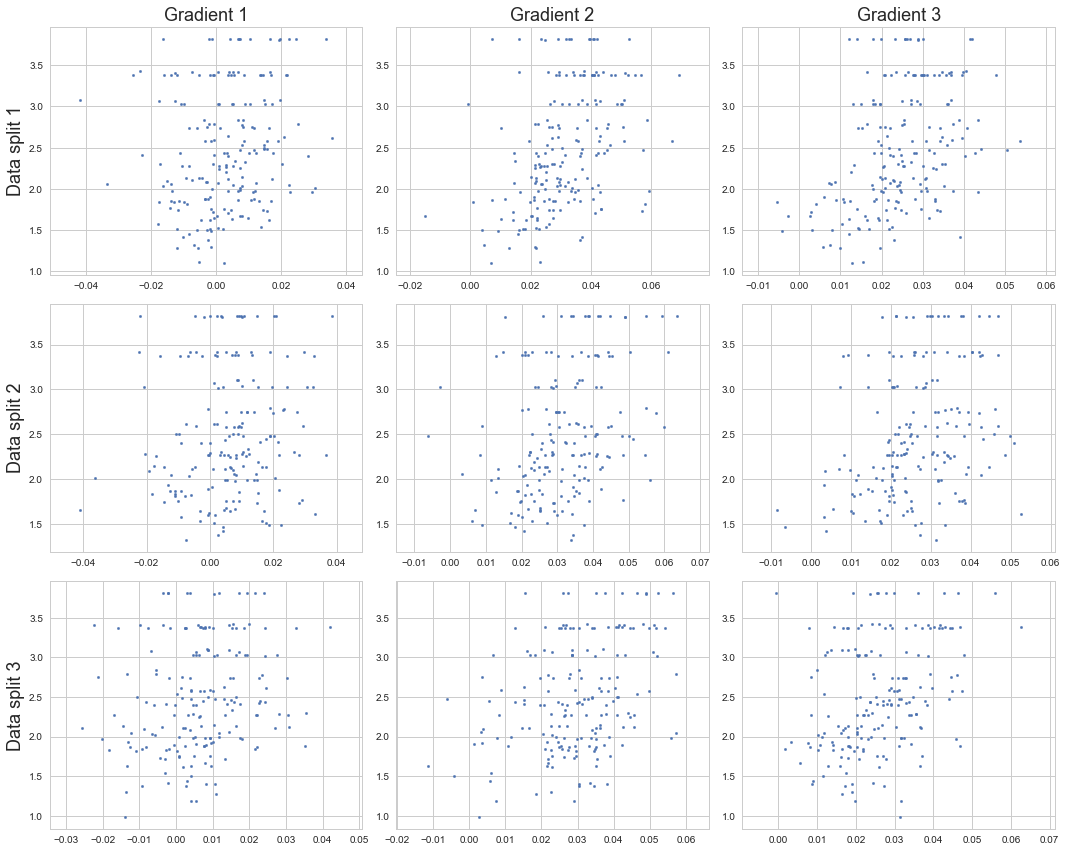

In [17]:
sns.set_style('whitegrid')
size = 6

fig = plt.figure(figsize = (15,12))

ax = fig.add_subplot(3,3,1)
ax.scatter(features_A_2b[:,0], targets_A_2b, s = size)
ax.set_ylabel('Data split 1', fontsize = 18)
ax.set_title('Gradient 1', fontsize = 18)

ax = fig.add_subplot(3,3,2)
ax.scatter(features_A_2b[:,1], targets_A_2b, s = size)
ax.set_title('Gradient 2', fontsize = 18)

ax = fig.add_subplot(3,3,3)
ax.scatter(features_A_2b[:,2], targets_A_2b, s = size)
ax.set_title('Gradient 3', fontsize = 18)

ax = fig.add_subplot(3,3,4)
ax.scatter(features_B_2b[:,0], targets_B_2b, s = size)
ax.set_ylabel('Data split 2', fontsize = 18)

ax = fig.add_subplot(3,3,5)
ax.scatter(features_B_2b[:,1], targets_B_2b, s = size)

ax = fig.add_subplot(3,3,6)
ax.scatter(features_B_2b[:,2], targets_B_2b, s = size)

ax = fig.add_subplot(3,3,7)
ax.scatter(features_C_2b[:,0], targets_C_2b, s = size)
ax.set_ylabel('Data split 3', fontsize = 18)

ax = fig.add_subplot(3,3,8)
ax.scatter(features_C_2b[:,1], targets_C_2b, s = size)

ax = fig.add_subplot(3,3,9)
ax.scatter(features_C_2b[:,2], targets_C_2b, s = size)

plt.tight_layout()

### 0-back

In [24]:
scaler = StandardScaler()
scaler.fit(f_WM_0b_t1)

features_A_0b = np.vstack([f_WM_0b_t1, f_WM_0b_t2])
features_B_0b = np.vstack([f_WM_0b_t3, f_WM_0b_t4])
features_C_0b = np.vstack([f_WM_0b_test1, f_WM_0b_test2])

targets_A_0b = np.concatenate([t_WM_0b_train1, t_WM_0b_train2])
targets_B_0b = np.concatenate([t_WM_0b_train3, t_WM_0b_train4])
targets_C_0b = np.concatenate([t_WM_0b_test1, t_WM_0b_test2])

In [25]:
predict_performance(features_A_0b, targets_A_0b, features_B_0b, targets_B_0b, features_C_0b, targets_C_0b)

Gradients   AIC   BIC   A (B, C)              AIC   BIC   B (A, C)              AIC   BIC   C (A, B)
[0]         626.8 633.2 0.03 (0.08, 0.08)     586.7 593.0 0.09 (0.02, 0.10)     586.1 592.5 0.10 (0.00, 0.09)
[1]         613.7 620.2 0.09 (0.04, -0.02)     594.1 600.5 0.05 (0.08, 0.01)     602.8 609.2 0.02 (0.06, 0.04)
[2]         562.6 569.1 0.30 (0.34, 0.35)     530.4 536.8 0.34 (0.30, 0.35)     527.9 534.3 0.35 (0.30, 0.33)
[0, 1]      613.1 622.8 0.10 (0.10, 0.04)     581.2 590.8 0.13 (0.08, 0.10)     586.2 595.8 0.11 (0.04, 0.12)
[0, 2]      564.3 574.1 0.31 (0.34, 0.36)     531.8 541.4 0.34 (0.31, 0.36)     525.4 535.0 0.37 (0.30, 0.33)
[1, 2]      560.9 570.7 0.32 (0.34, 0.32)     530.8 540.4 0.34 (0.32, 0.33)     528.6 538.2 0.35 (0.29, 0.32)
[0, 1, 2]   562.8 575.8 0.32 (0.34, 0.32)     532.2 544.9 0.34 (0.32, 0.34)     526.0 538.8 0.37 (0.28, 0.31)


In [20]:
ols = sm.OLS(targets_A_0b, sm.add_constant(features_A_0b))
ols = ols.fit(cov_type="HC1")
print ols.summary()
pred_0b_A_B = ols.predict(sm.add_constant(features_B_0b))
pred_0b_A_C = ols.predict(sm.add_constant(features_C_0b))

print "Variance explained (B): %.2f" % explained_variance_score(targets_B_0b, pred_0b_A_B)
print "Variance explained (C): %.2f" % explained_variance_score(targets_C_0b, pred_0b_A_C)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     37.56
Date:                Thu, 06 Apr 2017   Prob (F-statistic):           5.04e-19
Time:                        13:46:29   Log-Likelihood:                -277.40
No. Observations:                 190   AIC:                             562.8
Df Residuals:                     186   BIC:                             575.8
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3742      0.080     42.033      0.0

In [21]:
ols = sm.OLS(targets_B_0b, sm.add_constant(features_B_0b))
ols = ols.fit(cov_type="HC1")
print ols.summary()
pred_0b_B_A = ols.predict(sm.add_constant(features_A_0b))
pred_0b_B_C = ols.predict(sm.add_constant(features_C_0b))

print "Variance explained (A): %.2f" % explained_variance_score(targets_A_0b, pred_0b_B_A)
print "Variance explained (C): %.2f" % explained_variance_score(targets_C_0b, pred_0b_B_C)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     38.88
Date:                Thu, 06 Apr 2017   Prob (F-statistic):           2.51e-19
Time:                        13:46:29   Log-Likelihood:                -262.09
No. Observations:                 180   AIC:                             532.2
Df Residuals:                     176   BIC:                             544.9
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4105      0.080     42.710      0.0

In [22]:
ols = sm.OLS(targets_C_0b, sm.add_constant(features_C_0b))
ols = ols.fit(cov_type="HC1")
print ols.summary()
pred_2b_C_A = ols.predict(sm.add_constant(features_A_0b))
pred_2b_C_B = ols.predict(sm.add_constant(features_B_0b))

print "Variance explained (A): %.2f" % explained_variance_score(targets_A_0b, pred_2b_C_A)
print "Variance explained (C): %.2f" % explained_variance_score(targets_B_0b, pred_2b_C_B)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     45.03
Date:                Thu, 06 Apr 2017   Prob (F-statistic):           1.05e-21
Time:                        13:46:29   Log-Likelihood:                -259.01
No. Observations:                 182   AIC:                             526.0
Df Residuals:                     178   BIC:                             538.8
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3312      0.076     43.585      0.0

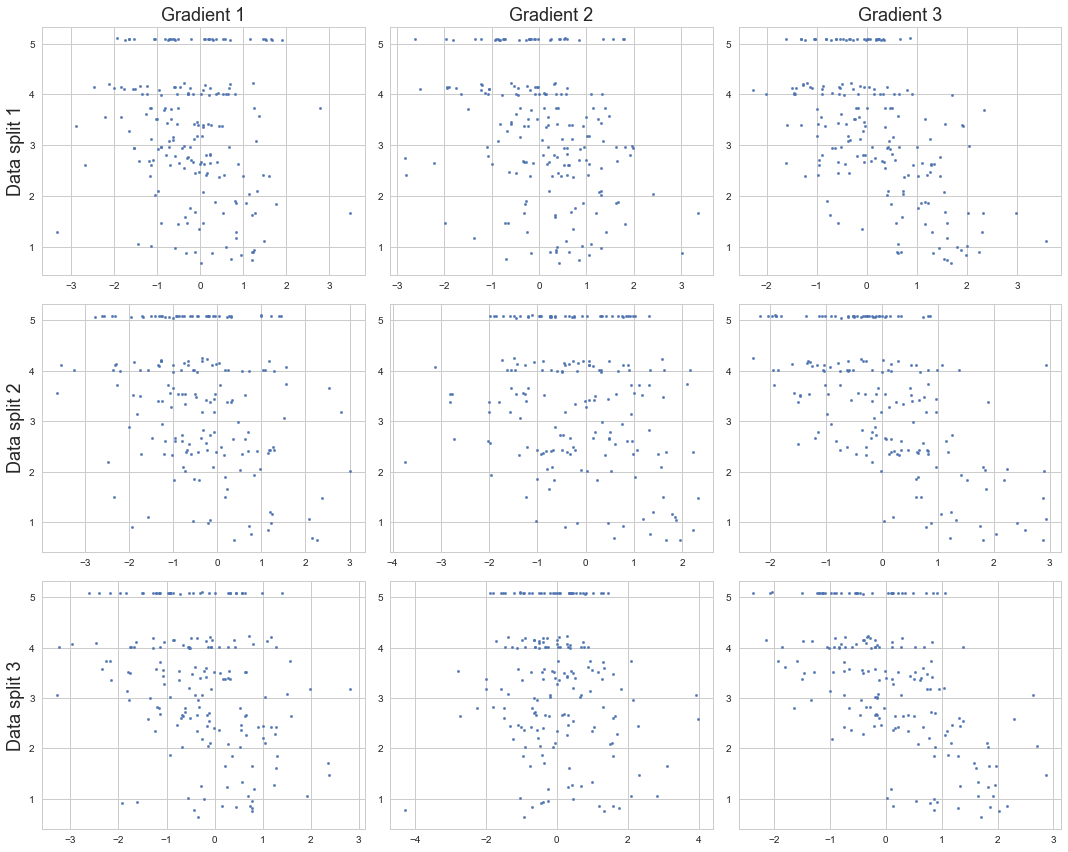

In [23]:
sns.set_style('whitegrid')
size = 6

fig = plt.figure(figsize = (15,12))

ax = fig.add_subplot(3,3,1)
ax.scatter(features_A_0b[:,0], targets_A_0b, s = size)
ax.set_ylabel('Data split 1', fontsize = 18)
ax.set_title('Gradient 1', fontsize = 18)

ax = fig.add_subplot(3,3,2)
ax.scatter(features_A_0b[:,1], targets_A_0b, s = size)
ax.set_title('Gradient 2', fontsize = 18)

ax = fig.add_subplot(3,3,3)
ax.scatter(features_A_0b[:,2], targets_A_0b, s = size)
ax.set_title('Gradient 3', fontsize = 18)

ax = fig.add_subplot(3,3,4)
ax.scatter(features_B_0b[:,0], targets_B_0b, s = size)
ax.set_ylabel('Data split 2', fontsize = 18)

ax = fig.add_subplot(3,3,5)
ax.scatter(features_B_0b[:,1], targets_B_0b, s = size)

ax = fig.add_subplot(3,3,6)
ax.scatter(features_B_0b[:,2], targets_B_0b, s = size)

ax = fig.add_subplot(3,3,7)
ax.scatter(features_C_0b[:,0], targets_C_0b, s = size)
ax.set_ylabel('Data split 3', fontsize = 18)

ax = fig.add_subplot(3,3,8)
ax.scatter(features_C_0b[:,1], targets_C_0b, s = size)

ax = fig.add_subplot(3,3,9)
ax.scatter(features_C_0b[:,2], targets_C_0b, s = size)

plt.tight_layout()